# DL Project - Gesture recognition undewater - CADDY Dataset
## Part 1 - Gesture Classification:


In [77]:
# imports for the practice (you can add more if you need)
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision import transforms, utils
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
import time
from google.colab import drive
from PIL import Image
drive.mount('/content/gdrive')
from shutil import copyfile


seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# unzip data
!unzip "/content/gdrive/MyDrive/CADDY_stereo_gesture_data/CADDY_gestures_complete_v2_release.zip"


Streaming output truncated to the last 5000 lines.
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00820_left.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00820_right.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00821_left.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00821_right.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00822_left.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00822_right.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00823_left.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00823_right.jpg  
  inflating: CADDY_gestures_complete_v2_release/genova-A/true_positives/raw/genova-A_00824_left.jpg  
  inflating: CADDY_gestures

In [78]:
#show dataset params

csv_path = '/content/CADDY_gestures_complete_v2_release/CADDY_gestures_all_true_positives_release_v2.csv'

csv_data = pd.read_csv(csv_path)
csv_data = csv_data.drop(csv_data[csv_data['synthetic'] == 1].index)
csv_data = csv_data.drop(csv_data[pd.isna(csv_data['roi left'])].index)
csv_data = csv_data.drop(csv_data[pd.isna(csv_data['roi right'])].index)
csv_data

,index,scenario,stereo left,stereo right,label name,...,iqa_mdm_d,iqa_mdm_dcomp,distortion,param 1,param 2
0,0,biograd-A,/biograd-A/true_positives/raw/biograd-A_00000_...,/biograd-A/true_positives/raw/biograd-A_00000_...,num_delimiter,...,0.957653,0.902000,NaN,NaN,NaN
10,10,biograd-A,/biograd-A/true_positives/raw/biograd-A_00001_...,/biograd-A/true_positives/raw/biograd-A_00001_...,num_delimiter,...,0.958442,0.885512,NaN,NaN,NaN
20,20,biograd-A,/biograd-A/true_positives/raw/biograd-A_00002_...,/biograd-A/true_positives/raw/biograd-A_00002_...,num_delimiter,...,0.958565,0.885733,NaN,NaN,NaN
30,30,biograd-A,/biograd-A/true_positives/raw/biograd-A_00003_...,/biograd-A/true_positives/raw/biograd-A_00003_...,num_delimiter,...,0.958243,0.885593,NaN,NaN,NaN
40,40,biograd-A,/biograd-A/true_positives/raw/biograd-A_00004_...,/biograd-A/true_positives/raw/biograd-A_00004_...,num_delimiter,...,0.955913,0.875217,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
92340,92340,genova-A,/genova-A/true_positives/raw/genova-A_03315_le...,/genova-A/true_positives/raw/genova-A_03315_ri...,end_comm,...,0.956023,0.907844,NaN,NaN,NaN
92350,92350,genova-A,/genova-A/true_positives/raw/genova-A_03316_le...,/genova-A/true_positives/raw/genova-A_03316_ri...,end_comm,...,0.951243,0.903453,NaN,NaN,NaN
92360,92360,genova-A,/genova-A/true_positives/raw/genova-A_03317_le...,/genova-A/true_positives/raw/genova-A_03317_ri...,end_comm,...,0.954676,0.906375,NaN,NaN,NaN
92370,92370,genova-A,/genova-A/true_positives/raw/genova-A_03318_le...,/genova-A/true_positives/raw/genova-A_03318_ri...,end_comm,...,0.950583,0.910386,NaN,NaN,NaN


In [79]:
def get_coor_params(coor):
    if coor.find(';')!=-1:
        coor = coor[1: coor.index(';')].split(',')
    else:
        coor = coor[1: len(coor)-1].split(',')
    return list(map(int, coor))

In [80]:
#creating dataset for torch, cutted
class CADDYGestureDataset(Dataset):
    """CADDY gesture dataset."""

    def __init__(self, csv_path, images_path, transform=None, mean=None, std=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.gesture_frame = pd.read_csv(csv_path)
        self.gesture_frame = self.gesture_frame.drop(self.gesture_frame[self.gesture_frame['synthetic'] == 1].index)
        self.gesture_frame = self.gesture_frame.drop(self.gesture_frame[pd.isna(self.gesture_frame['roi left'])].index)
        self.gesture_frame = self.gesture_frame.drop(self.gesture_frame[pd.isna(self.gesture_frame['roi right'])].index)
        self.images_path = images_path
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.gesture_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        imgL_name = self.gesture_frame.iloc[idx, 2]
        imgR_name = self.gesture_frame.iloc[idx, 3]
        label = self.gesture_frame.iloc[idx, 5]

        [xL, yL, widthL, heightL] = get_coor_params(self.gesture_frame.iloc[idx, 6])
        [xR, yR, widthR, heightR] = get_coor_params(self.gesture_frame.iloc[idx, 7])

        imgL_path = self.images_path + imgL_name
        imgR_path = self.images_path + imgR_name

        imgL = transforms.ToTensor()(Image.open(imgL_path))
        imgR = transforms.ToTensor()(Image.open(imgR_path))

        imgL_cut = transforms.Resize((32,32))(imgL[:,yL:yL+heightL,xL:xL+widthL])
        imgR_cut = transforms.Resize((32,32))(imgR[:,yR:yR+heightR,xR:xR+widthR])

        sample = {'imageL': imgL_cut, 'imageR': imgR_cut, 'label': label}

        if self.mean is not None:
            imgL_cut_norm = transforms.functional.normalize(imgL_cut, self.mean, self.std)
            imgR_cut_norm = transforms.functional.normalize(imgR_cut, self.mean, self.std)
            sample = {'imageL': imgL_cut_norm, 'imageR': imgR_cut_norm, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

14


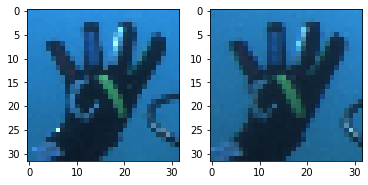

In [82]:
CADDY_gesture_dataset = CADDYGestureDataset(csv_path='/content/CADDY_gestures_complete_v2_release/CADDY_gestures_all_true_positives_release_v2.csv',
                                            images_path="/content/CADDY_gestures_complete_v2_release")

sample0 = CADDY_gesture_dataset[656]

print(sample0['label'])

fig, _axs = plt.subplots(nrows=1, ncols=2)
axs = _axs.flatten()

axs[0].imshow(sample0['imageL'].numpy().transpose(1,2,0))
axs[1].imshow(sample0['imageR'].numpy().transpose(1,2,0))

plt.show()


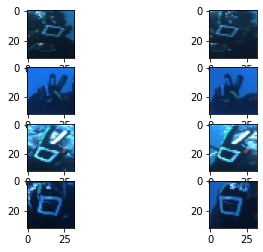

In [83]:
# read data as batches
batch_size = 4
dataloader = DataLoader(CADDY_gesture_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)
dataiter = iter(dataloader)
sample_batched = dataiter.next()
imagesL_batch, imagesR_batch, labels_batch = \
            sample_batched['imageL'], sample_batched['imageR'], sample_batched['label']

fig, _axs = plt.subplots(nrows=batch_size, ncols=2)
axs = _axs.flatten()

for i in range(batch_size):
    axs[2*i].imshow(imagesL_batch[i].numpy().transpose(1,2,0))
    axs[2*i+1].imshow(imagesR_batch[i].numpy().transpose(1,2,0))

plt.show()


In [84]:
#split dataset to train, val and test sets
CADDY_gesture_dataset = CADDYGestureDataset(csv_path='/content/CADDY_gestures_complete_v2_release/CADDY_gestures_all_true_positives_release_v2.csv',
                                            images_path="/content/CADDY_gestures_complete_v2_release")
indices = list(range(len(CADDY_gesture_dataset)))
np.random.shuffle(indices)

size_trainset = int(np.floor(len(CADDY_gesture_dataset)*0.6))
size_valset = int(np.floor(len(CADDY_gesture_dataset)*0.2))

trainset = Subset(CADDY_gesture_dataset, indices[:size_trainset])


In [85]:
#Find mean and std of data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
size_trainset = len(trainset)

mean_trainset_vect = np.zeros((size_trainset*2, 3))
var_trainset_vect = np.zeros((size_trainset*2, 3))

for i, data in enumerate(trainloader, 0):
    imagesL_batch, imagesR_batch = data['imageL'], data['imageR']
    mean_trainset_vect[2*i,:] = [imagesL_batch[0,j,:,:].mean() for j in range(3)]
    var_trainset_vect[2*i, :] = [imagesL_batch[0,j,:,:].var() for j in range(3)]
    mean_trainset_vect[2*i+1,:] = [imagesR_batch[0,j,:,:].mean() for j in range(3)]
    var_trainset_vect[2*i+1, :] = [imagesR_batch[0,j,:,:].var() for j in range(3)]

mean_trainset = np.mean(mean_trainset_vect,axis=0)
std_trainset = np.square(np.mean(var_trainset_vect,axis=0))

print(mean_trainset)
print(std_trainset)

[    0.12194     0.29863     0.43273]
[ 0.00018679   0.0010484   0.0027786]


In [86]:

CADDY_gesture_dataset_norm = CADDYGestureDataset(csv_path='/content/CADDY_gestures_complete_v2_release/CADDY_gestures_all_true_positives_release_v2.csv',
                                            images_path="/content/CADDY_gestures_complete_v2_release",
                                            mean = mean_trainset, std=std_trainset)

trainset = Subset(CADDY_gesture_dataset_norm, indices[:size_trainset])
valset = Subset(CADDY_gesture_dataset_norm, indices[size_trainset:size_trainset+size_valset])
testset = Subset(CADDY_gesture_dataset_norm, indices[size_trainset+size_valset:])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


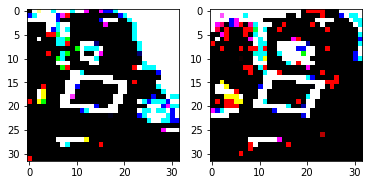

In [87]:
sample0 = CADDY_gesture_dataset_norm[282]

print(sample0['label'])

fig, _axs = plt.subplots(nrows=1, ncols=2)
axs = _axs.flatten()

axs[0].imshow(sample0['imageL'].numpy().transpose(1,2,0))
axs[1].imshow(sample0['imageR'].numpy().transpose(1,2,0))

plt.show()

In [88]:
#Impliment CNN architecture
class CaddyCNN(nn.Module):
 def __init__(self):
    super(CaddyCNN, self).__init__()
    
    self.conv_layer = nn.Sequential(
      # Conv Layer block 1 (32x32x3 -> 32x32x32 -> 32x32x64 -> 16x16x64)
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      # Conv Layer block 2 (16x16x64 -> 16x16x128 -> 16x16x128 -> 8x8x128)
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Dropout2d(p=0.05),
      # Conv Layer block 3  (8x8x128 -> 8x8x256 -> 8x8x256 -> 4x4x256)
      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=2, stride=2),
 )

    self.fc_layer = nn.Sequential(
    nn.Linear(256*4*4, 256*4),
    nn.ReLU(inplace=True),
    nn.Linear(256*4, 256*2),
    nn.ReLU(inplace=True),
    nn.Linear(256*2, 16)
 )
 def forward(self, x):
    # conv layers
    x = self.conv_layer(x)
    
    # flatten
    x = x.view(x.size(0), -1)

    # fc layer
    x = self.fc_layer(x)
    return x

In [89]:
# time to train our model and choose Hyperparms
# hyper-parameters
batch_size = 64
learning_rate = 1e-4
epochs = 20 # initail, checking on val for the right amount on epocs

# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(
 trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(
 valset, batch_size=batch_size, shuffle=False, num_workers=2)

# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# loss criterion
criterion = nn.CrossEntropyLoss()
# build our model and send it to the device
model = CaddyCNN().to(device) # no need for parameters as we alredy defined them in the class
# optimizer - Adam
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [90]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([16,16], int)
    with torch.no_grad():
      for data in dataloader:
        imagesL, imagesR, labels = data['imageL'], data['imageR'], data['label']
        images = imagesL
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
          confusion_matrix[l.item(), predicted[i].item()] += 1

    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [91]:
# training loop on val
train_loss_list = []
val_loss_list = []
for epoch in range(1, epochs + 1):
    model.train() # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        imagesL, imagesR, labels = data['imageL'], data['imageR'], data['label']
        inputs = imagesL
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward() # backpropagation
        optimizer.step() # update parameters
        # print statistics
        running_loss += loss.data.item()
        # Normalizing the loss by the total number of train batches
        running_loss /= len(trainloader)

    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    val_accuracy, _ = calculate_accuracy(model, valloader, device)
    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Val accuracy: {:.3f}% | ".format(epoch
    , running_loss, train_accuracy, val_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)
    train_loss_list.append(train_accuracy)
    val_loss_list.append(val_accuracy)
    
    # save model
    if val_accuracy > 99 or epoch == 20: 
      print('==> Saving model ...')
      state = {
      'net': model.state_dict(),
      'epoch': epoch,
      }
      if not os.path.isdir('checkpoints'):
        os.mkdir('checkpoints')
      torch.save(state, './checkpoints/caddy_cnn_ckpt1.pth')
      break


print('==> Finished Training ...')

Epoch: 1 | Loss: 0.0053 | Training accuracy: 73.706% | Val accuracy: 71.531% | Epoch Time: 148.62 secs
Epoch: 2 | Loss: 0.0047 | Training accuracy: 90.734% | Val accuracy: 87.500% | Epoch Time: 149.16 secs
Epoch: 3 | Loss: 0.0004 | Training accuracy: 96.661% | Val accuracy: 94.053% | Epoch Time: 153.50 secs
Epoch: 4 | Loss: 0.0005 | Training accuracy: 97.101% | Val accuracy: 94.824% | Epoch Time: 151.11 secs
Epoch: 5 | Loss: 0.0001 | Training accuracy: 98.128% | Val accuracy: 94.934% | Epoch Time: 149.89 secs
Epoch: 6 | Loss: 0.0009 | Training accuracy: 99.303% | Val accuracy: 96.641% | Epoch Time: 149.99 secs
Epoch: 7 | Loss: 0.0000 | Training accuracy: 99.505% | Val accuracy: 96.256% | Epoch Time: 149.60 secs
Epoch: 8 | Loss: 0.0000 | Training accuracy: 99.761% | Val accuracy: 97.467% | Epoch Time: 149.31 secs
Epoch: 9 | Loss: 0.0001 | Training accuracy: 97.706% | Val accuracy: 94.548% | Epoch Time: 148.61 secs
Epoch: 10 | Loss: 0.0007 | Training accuracy: 99.651% | Val accuracy: 96.

val accuracy: 98.403%


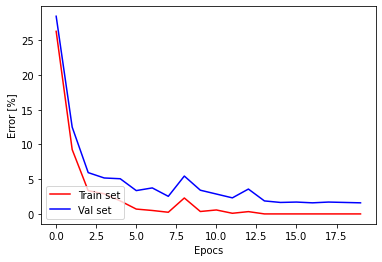

<Figure size 432x288 with 0 Axes>

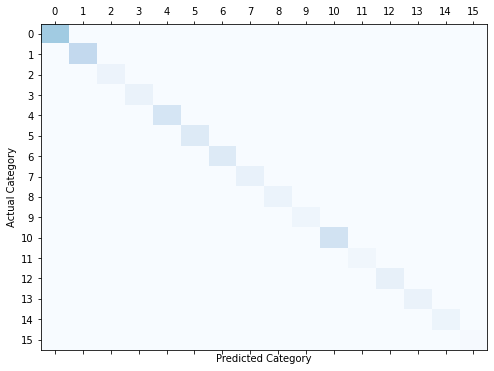

In [92]:
classes = range(16)

#Get CNN accuracy
model = CaddyCNN().to(device)
state = torch.load('./checkpoints/caddy_cnn_ckpt1.pth', map_location=device)
model.load_state_dict(state['net'])
val_accuracy, confusion_matrix = calculate_accuracy(model, valloader, device)
print("val accuracy: {:.3f}%".format(val_accuracy))

epocs_array = np.array(range(epoch))
train_loss_array = np.array(train_loss_list)
val_loss_array = np.array(val_loss_list)

# plot train and test loss
plt.figure(1)
plt.plot(epocs_array, 100 - train_loss_array, 'r', epocs_array, 100 - val_loss_array, 'b')
plt.xlabel('Epocs')
plt.ylabel('Error [%]')
plt.legend(["Train set", "Val set"], loc ="lower left")
plt.show()

# plot confusion matrix
plt.figure(2)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(len(classes)), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(len(classes)), classes)
plt.show()

## Part 2 - Hand Localization using YOLOv5 (state of the art for June 2020)
using YOLOv5 training tutorial from here: 
https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb#scrollTo=gogI-kwi3Tye

In [60]:
#!rm -rf '/content/data/images'
#!rm -rf '/content/data/labels'
#!rm -rf '/content/testset'

In [4]:
# creating directories for localization dataset 
new_images_path = '/content/data/images/'
new_txt_path = '/content/data/labels/'
images_path="/content/CADDY_gestures_complete_v2_release"

width_im, height_im = Image.open(images_path+csv_data.iloc[0, 2]).size
print('width - {}, height - {}'.format(width_im, height_im))

if not os.path.isdir(new_images_path+'/train/'):
        os.makedirs(new_images_path+'/train/')
if not os.path.isdir(new_txt_path+'/train/'):
        os.makedirs(new_txt_path+'/train/')

if not os.path.isdir(new_images_path+'/valid/'):
        os.makedirs(new_images_path+'/valid/')
if not os.path.isdir(new_txt_path+'/valid/'):
        os.makedirs(new_txt_path+'/valid/')

if not os.path.isdir('/content/testset/images/'):
        os.makedirs('/content/testset/images/')
if not os.path.isdir('/content/testset/labels/'):
        os.makedirs('/content/testset/labels/')


In [5]:
#setup Yolov5
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (Tesla T4)


In [6]:
#creating indices for train and valid
train_indices = indices[:size_trainset]
valid_indices = indices[size_trainset:size_trainset+size_valset]
test_indices = indices[size_trainset+size_valset:]

#using smaller dataset
train_smaller_indices = train_indices[:np.floor(size_trainset/3)]
valid_smaller_indices = valid_indices[:np.floor(size_valset/3)]
test_smaller_indices = test_indices[:np.floor(size_valset/3)]

print('small trainset size - {}, small valset size - {}'.format(len(train_smaller_indices)*2, len(valid_smaller_indices)*2))

trainset size - 3632, valset size - 1210


In [7]:
def get_str_coor_norm(coor, width_im, height_im):
    [x, y, width, height] = list(map(int, coor[1: len(coor)-1].split(',')))
    x_center_norm = (x + width/2)/width_im
    y_center_norm = (y + height/2)/height_im
    width_norm = width/width_im
    height_norm = height/height_im
    return '0 '+str(x_center_norm)+' '+str(y_center_norm)+' '+str(width_norm)+' '+str(height_norm)+'\n'

In [ ]:
def prep_data_for_yolo(csv_data, images_path, new_images_path, new_txt_path, width_im, height_im, data_type, data_indices):
  for idx in data_indices:
    imgL_name = csv_data.iloc[idx, 2]
    imgR_name = csv_data.iloc[idx, 3]
    imageL_path = images_path + imgL_name
    imageR_path = images_path + imgR_name
    
    if data_type == 'train':
      newL_path = new_images_path + '/train/' + os.path.split(imageL_path)[1]
      newR_path = new_images_path + '/train/' + os.path.split(imageR_path)[1]
    elif data_type == 'valid':
      newL_path = new_images_path + '/valid/' + os.path.split(imageL_path)[1]
      newR_path = new_images_path + '/valid/' + os.path.split(imageR_path)[1]
    else:
      newL_path = '/content/testset/images/' + os.path.split(imageL_path)[1]
      newR_path = '/content/testset/images/' + os.path.split(imageR_path)[1]
    
    copyfile(imageL_path, newL_path)
    copyfile(imageR_path, newR_path)

    #label = csv_data.iloc[idx, 5]
    coorL = csv_data.iloc[idx, 6]
    coorR = csv_data.iloc[idx, 7]
    
    if data_type == 'train':
      textL_path = new_txt_path + '/train/' + os.path.split(imageL_path)[1][:-4] +'.txt'
      textR_path = new_txt_path + '/train/' + os.path.split(imageR_path)[1][:-4] +'.txt'
    elif data_type == 'valid':
      textL_path = new_txt_path + '/valid/' + os.path.split(imageL_path)[1][:-4] +'.txt'
      textR_path = new_txt_path + '/valid/' + os.path.split(imageR_path)[1][:-4] +'.txt'
    else:
      textL_path = '/content/testset/labels/' + os.path.split(imageL_path)[1][:-4] +'.txt'
      textR_path = '/content/testset/labels/' + os.path.split(imageR_path)[1][:-4] +'.txt'

    textL_file = open(textL_path, "w")
    if coorL.find(';')==-1:
        strL = get_str_coor_norm(coorL, width_im, height_im)
        textL_file.write(strL)
    else:
        coorL1 = coorL[: coorL.index(';')+1]
        coorL2 = coorL[coorL.index(';'):len(coorL)]
        strL1 = get_str_coor_norm(coorL1, width_im, height_im)
        strL2 = get_str_coor_norm(coorL2, width_im, height_im)
        textL_file.write(strL1)
        textL_file.write(strL2)
    textL_file.close()

    textR_file = open(textR_path, "w")
    if coorR.find(';')==-1:
        strR = get_str_coor_norm(coorR, width_im, height_im)
        textR_file.write(strR)
    else:
        coorR1 = coorR[: coorR.index(';')+1]
        coorR2 = coorR[coorR.index(';'):len(coorR)]
        strR1 = get_str_coor_norm(coorR1, width_im, height_im)
        strR2 = get_str_coor_norm(coorR2, width_im, height_im)
        textR_file.write(strR1)
        textR_file.write(strR2)
    textR_file.close()

In [11]:
# creating directories and organizing data for yolo
prep_data_for_yolo(csv_data, images_path, new_images_path, new_txt_path, width_im, height_im, 'train', train_indices):
prep_data_for_yolo(csv_data, images_path, new_images_path, new_txt_path, width_im, height_im, 'valid', valid_indices):
prep_data_for_yolo(csv_data, images_path, new_images_path, new_txt_path, width_im, height_im, 'test', test_indices):

In [14]:
ymal_path = '/content/gdrive/MyDrive/CADDY_stereo_gesture_data/caddy_loc.yaml'
copyfile(ymal_path, '/content/caddy_loc.yaml')

'/content/caddy_loc.yaml'

In [15]:
# Train YOLOv5s on CADDY for 100 epochs
!python train.py --img 640 --rect --batch 64 --epochs 100 --data /content/caddy_loc.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/caddy_loc.yaml, hyp=data/hyp.scratch.yaml, epochs=100, batch_size=64, img_size=[640], rect=True, resume=False, nosave=False, notest=False, noautoanchor=False, evolve=False, bucket=, cache_images=True, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-226-g6306091 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0

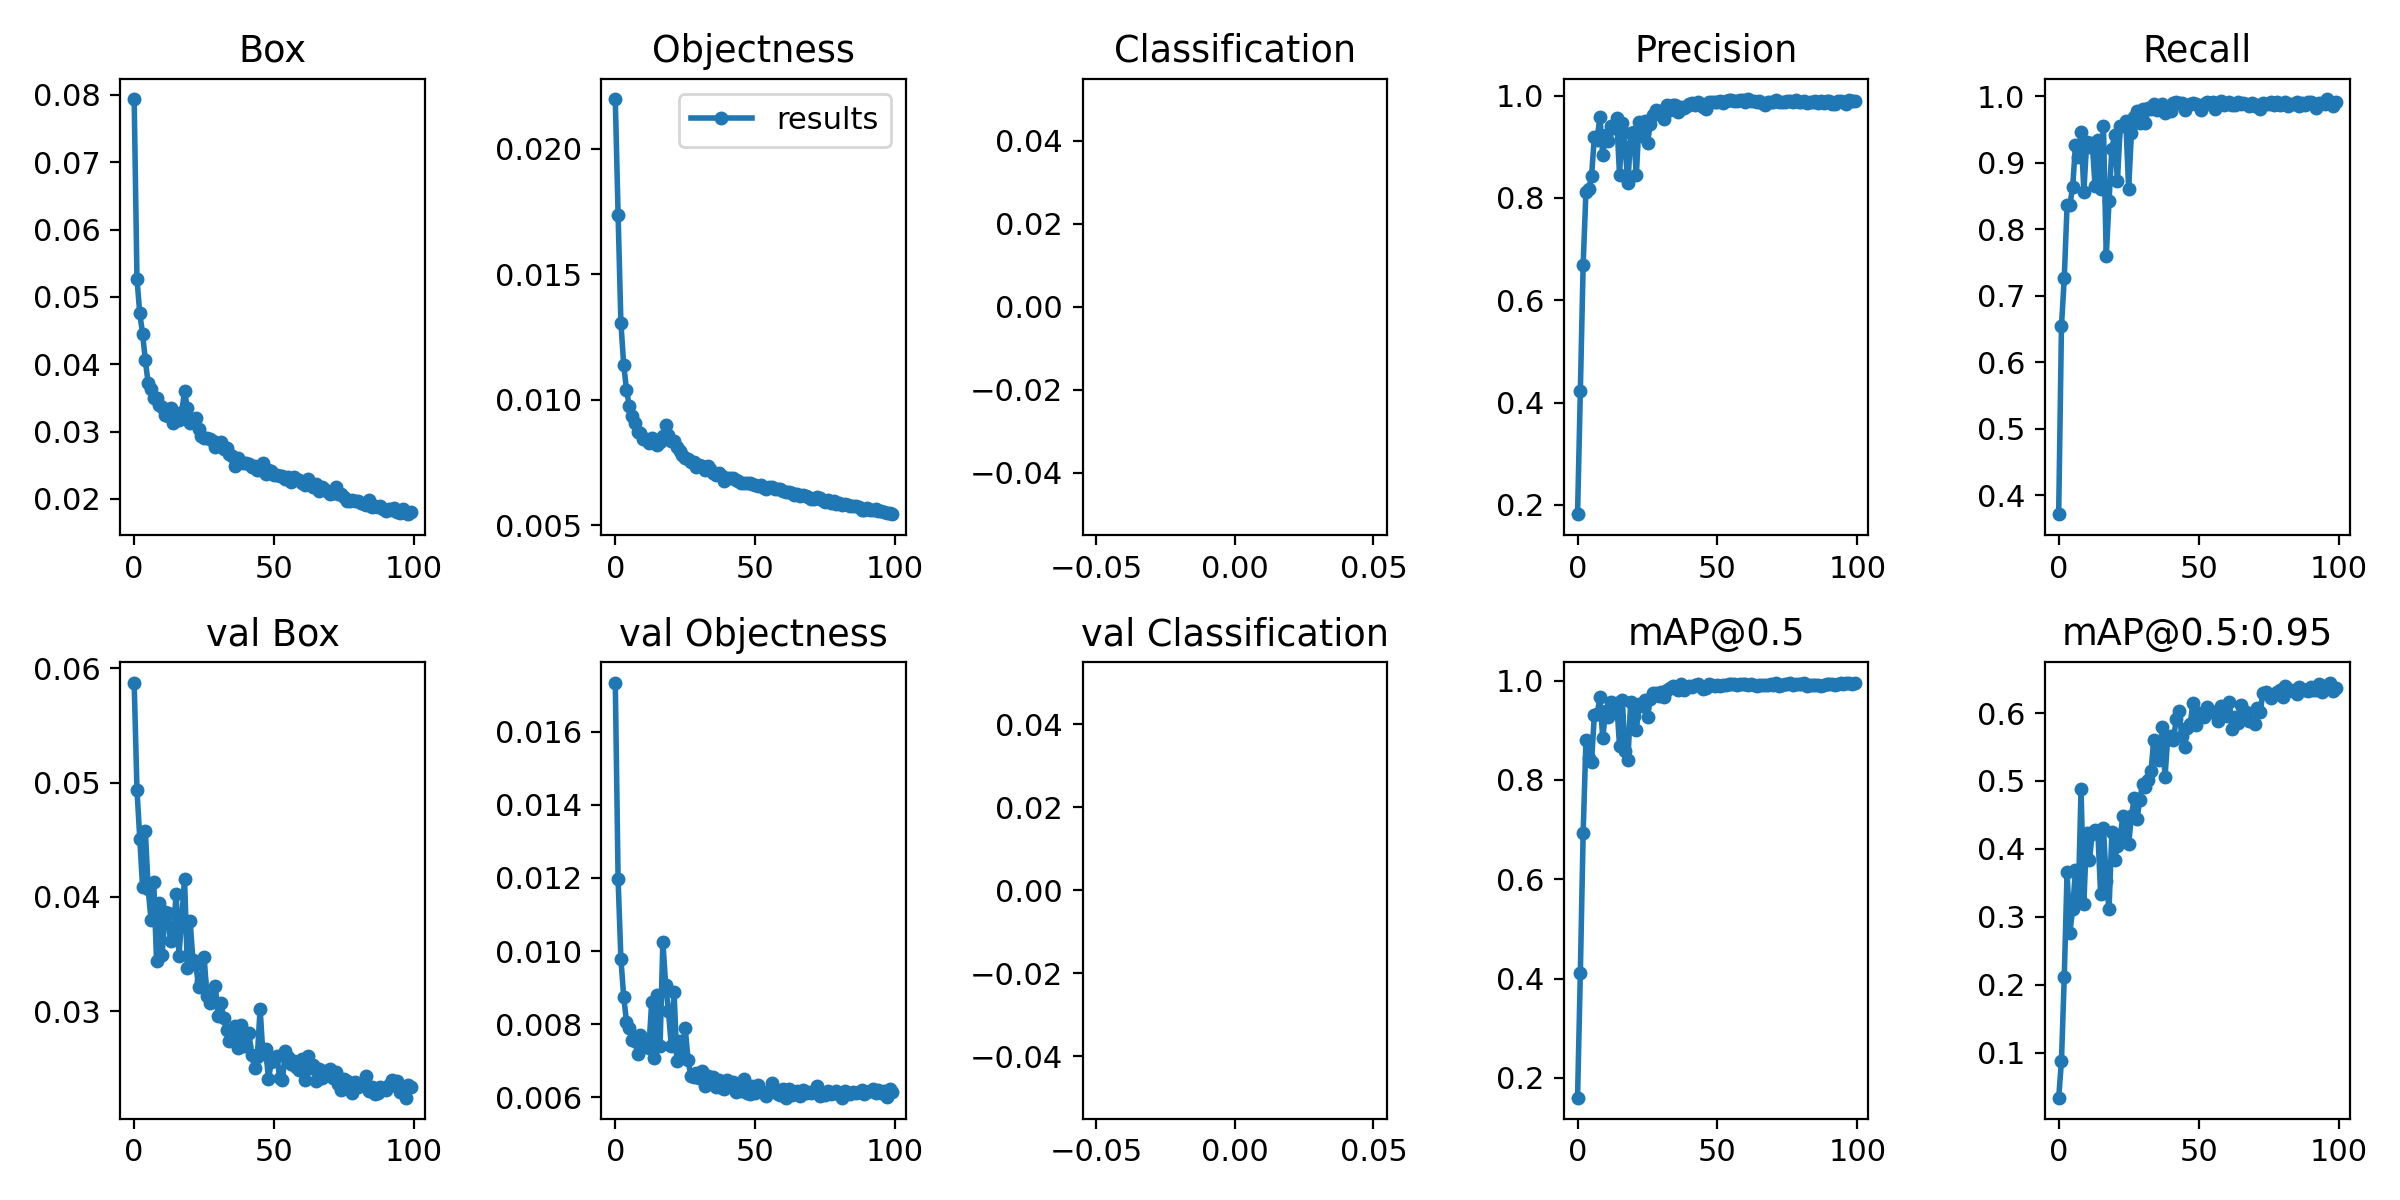

In [16]:
from utils.plots import plot_results 
plot_results(save_dir='/content/yolov5/runs/train/exp')  # plot all results*.txt as results.png
Image(filename='/content/yolov5/runs/train/exp/results.png', width=800)

In [17]:
# Run YOLOv5s on CADDY testset
!python test.py --weights /content/yolov5/runs/train/exp/weights/best.pt --data /content/caddy_loc.yaml --task test 

test: data=/content/caddy_loc.yaml, weights=['/content/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=test, device=, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/test, name=exp, exist_ok=False, half=False
YOLOv5 🚀 v5.0-226-g6306091 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
test: Scanning '/content/testset/labels' images and labels...1210 found, 0 missing

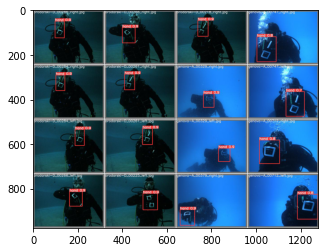

In [93]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

pred_batch_2_im = Image.open('/content/yolov5/runs/test/exp/test_batch2_pred.jpg')

plt.imshow(pred_batch_2_im)


## Part 3 - Testing the Full System


In [94]:
def get_coor_params_by_yolo(yolo_model, img_path):
    results = yolo_model(img_path).pandas().xyxy[0]
    loc_idx = results['confidence'].argmax()
    best_result = np.array(results.iloc[loc_idx].values)
    [x_min, y_min, x_max, y_max] = best_result[:4]
    x_min = int(np.floor(x_min))
    y_min = int(np.floor(y_min))
    width = int(np.ceil(x_max-x_min))
    height = int(np.ceil(y_max-y_min))
    return [x_min, y_min, width, height]

In [95]:
#creating dataset for torch, cutted
class CADDYGestureDatasetAfterLoc(Dataset):
    """CADDY gesture dataset using trained yolo."""

    def __init__(self, csv_path, images_path, yolo_model, transform=None, mean=None, std=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.gesture_frame = pd.read_csv(csv_path)
        self.gesture_frame = self.gesture_frame.drop(self.gesture_frame[self.gesture_frame['synthetic'] == 1].index)
        self.gesture_frame = self.gesture_frame.drop(self.gesture_frame[pd.isna(self.gesture_frame['roi left'])].index)
        self.gesture_frame = self.gesture_frame.drop(self.gesture_frame[pd.isna(self.gesture_frame['roi right'])].index)
        self.yolo_model = yolo_model
        self.images_path = images_path
        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.gesture_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        imgL_name = self.gesture_frame.iloc[idx, 2]
        imgR_name = self.gesture_frame.iloc[idx, 3]
        label = self.gesture_frame.iloc[idx, 5]

        imgL_path = self.images_path + imgL_name
        imgR_path = self.images_path + imgR_name

        imgL = transforms.ToTensor()(Image.open(imgL_path))
        imgR = transforms.ToTensor()(Image.open(imgR_path))

        [xL, yL, widthL, heightL] = get_coor_params_by_yolo(self.yolo_model, imgL_path)
        [xR, yR, widthR, heightR] = get_coor_params_by_yolo(self.yolo_model, imgR_path)

        imgL_cut = transforms.Resize((32,32))(imgL[:,yL:yL+heightL,xL:xL+widthL])
        imgR_cut = transforms.Resize((32,32))(imgR[:,yR:yR+heightR,xR:xR+widthR])

        sample = {'imageL': imgL_cut, 'imageR': imgR_cut, 'label': label}

        if self.mean is not None:
            imgL_cut_norm = transforms.functional.normalize(imgL_cut, self.mean, self.std)
            imgR_cut_norm = transforms.functional.normalize(imgR_cut, self.mean, self.std)
            sample = {'imageL': imgL_cut_norm, 'imageR': imgR_cut_norm, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [96]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5/runs/train/exp/weights/best.pt')
CADDY_dataset_after_loc = CADDYGestureDatasetAfterLoc(csv_path='/content/CADDY_gestures_complete_v2_release/CADDY_gestures_all_true_positives_release_v2.csv',
                                            images_path="/content/CADDY_gestures_complete_v2_release",
                                            yolo_model = yolo_model,
                                            mean = mean_trainset, std = std_trainset)
testset = Subset(CADDY_dataset_after_loc, test_indices)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


Fusing layers... 



requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
Adding AutoShape... 
YOLOv5 🚀 v5.0-226-g6306091 torch 1.9.0+cu102 CUDA:0 (Tesla T4, 15109.75MB)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


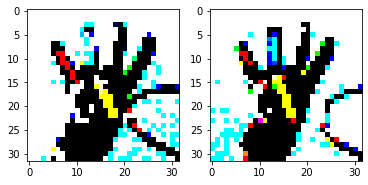

In [97]:

sample0 = CADDY_dataset_after_loc[650]


fig, _axs = plt.subplots(nrows=1, ncols=2)
axs = _axs.flatten()

axs[0].imshow(sample0['imageL'].numpy().transpose(1,2,0))
axs[1].imshow(sample0['imageR'].numpy().transpose(1,2,0))


In [100]:

#Get CNN accuracy
model = CaddyCNN().to(device)
state = torch.load('./checkpoints/caddy_cnn_ckpt1.pth', map_location=device)
model.load_state_dict(state['net'])
test_accuracy, _ = calculate_accuracy(model, testloader, device)
print("Final test accuracy: {:.3f}%".format(test_accuracy))


RuntimeError: ignored